In [262]:
import pandas as pd 
import geopandas as gpd
from geopandas import GeoDataFrame
import os
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pylab as plt
import math

pd.options.mode.chained_assignment = None
%matplotlib inline

In [199]:
path = "~/DRAW/Prediction/"

In [200]:
#Combine hoiusing sale data from 2011 to 2016 in one file 
dfs_list = []
for i in range(2011, 2016):
    temp_df = pd.read_excel('{}/{}_brooklyn.xls'.format(path, i), skiprows=4)
    temp_df.rename(columns=lambda x: x.strip(), inplace=True)

    dfs_list.append(temp_df)
pv_df = pd.concat(dfs_list)
pv_df.shape

(119783, 21)

In [201]:
pv_df.to_csv("brooklyn_prices_2011-16.csv")

In [202]:
# Convert five years data into csv file
price = pd.read_csv("brooklyn_prices_2011-16.csv")
bk_price=price.drop(['Unnamed: 0'], axis=1)
bk_price.head()

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,3,BATH BEACH,01 ONE FAMILY HOMES,1,6373,88,,A1,92 BAY 23RD STREET,,...,1,0,1,2790,1376,1940,1,A1,0,2011-02-08
1,3,BATH BEACH,01 ONE FAMILY HOMES,1,6380,71,,A5,8668 BAY PARKWAY,,...,1,0,1,1740,1782,1960,1,A5,610000,2011-10-24
2,3,BATH BEACH,01 ONE FAMILY HOMES,1,6399,4,,S1,1665 BATH AVENUE,,...,1,1,2,1260,1440,1940,1,S1,0,2011-07-11
3,3,BATH BEACH,01 ONE FAMILY HOMES,1,6399,7,,S1,1657 BATH AVENUE,,...,1,1,2,1260,1440,1930,1,S1,468000,2011-06-13
4,3,BATH BEACH,01 ONE FAMILY HOMES,1,6408,48,,S1,1967 BATH AVENUE,,...,1,1,2,1583,2052,1920,1,S1,0,2011-11-11


In [203]:
bk_price.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

In [205]:
# Find data in study area (Use the area file that Ben upload on Github)
pluto =  GeoDataFrame.from_file('pluto.geojson')
pluto.head()

,address,bbl,geometry
0,3 2 PLACE,3003600055,"(POLYGON ((-74.00071 40.680854, -74.000809 40...."
1,3 1 PLACE,3003550049,"(POLYGON ((-74.00028 40.681732, -74.000411 40...."
2,WARREN STREET,3003050121,"(POLYGON ((-73.998088 40.688107, -73.998119 40..."
3,94 DEGRAW STREET,3003290021,"(POLYGON ((-74.003272 40.6859, -74.003399 40.6..."
4,146 DEGRAW STREET,3003300020,"(POLYGON ((-74.001373 40.685371, -74.001498 40..."


In [206]:
# Join Pluto with housing data by using code that creat by Ben 
def format_bbl(parcel):
    borough = str(parcel['BOROUGH'])
    block = str(parcel['BLOCK'])
    lot = str(parcel['LOT'])
    return int(borough + block.zfill(5) + lot.zfill(4))

In [207]:
# Create bbls
bk_price['BBL'] = bk_price.apply(format_bbl, axis=1)

In [208]:
study_area_prices = bk_price[bk_price.apply(lambda parcel: parcel['BBL'] in pluto['bbl'].values, axis=1)]
study_area_prices.head(10)

,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,...,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,BBL
6140,3,CARROLL GARDENS,01 ONE FAMILY HOMES,1,350,29,,A4,428 CLINTON STREET,,...,0,1,1250,2400,1899,1,A4,0,2011-12-08,3003500029
6141,3,CARROLL GARDENS,01 ONE FAMILY HOMES,1,350,30,,A4,428A CLINTON STREET,,...,0,1,1250,2400,1899,1,A4,0,2011-12-06,3003500030
6143,3,CARROLL GARDENS,01 ONE FAMILY HOMES,1,429,66,,A5,375 UNION STREET,,...,0,1,1980,4164,1920,1,A5,0,2011-10-21,3004290066
6144,3,CARROLL GARDENS,01 ONE FAMILY HOMES,1,478,27,,S1,484 SMITH STREET,,...,1,2,1500,1160,1931,1,S1,0,2011-10-05,3004780027
6145,3,CARROLL GARDENS,02 TWO FAMILY HOMES,1,344,32,,B9,408A CLINTON STREET,,...,0,2,1361,3360,1899,1,B9,1600600,2011-06-30,3003440032
6146,3,CARROLL GARDENS,02 TWO FAMILY HOMES,1,373,28,,B1,42 4TH PLACE,3,...,0,2,2100,3528,1899,1,B1,1699999,2011-07-27,3003730028
6147,3,CARROLL GARDENS,02 TWO FAMILY HOMES,1,377,50,,B9,149 NELSON STREET,,...,0,2,1650,2112,1901,1,B9,525000,2011-09-09,3003770050
6148,3,CARROLL GARDENS,02 TWO FAMILY HOMES,1,379,35,,S2,520 COURT STREET,,...,1,3,1600,3000,1931,1,S2,0,2011-06-04,3003790035
6149,3,CARROLL GARDENS,02 TWO FAMILY HOMES,1,379,35,,S2,520 COURT STREET,,...,1,3,1600,3000,1931,1,S2,0,2011-04-02,3003790035
6150,3,CARROLL GARDENS,02 TWO FAMILY HOMES,1,381,21,,B9,158 HUNTINGTON STREET,,...,0,2,1667,1776,1901,1,B9,0,2011-12-08,3003810021


## Explantory Analysis on property sale price in study area 

In [209]:
study_area_prices.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE', 'BBL'],
      dtype='object')

In [210]:
study_area_prices.describe()

,BOROUGH,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,BBL
count,1854.0,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1854.000000,1.854000e+03,1.854000e+03
mean,3.0,405.282632,30.168824,11225.756742,2.286947,0.288026,2.572276,4287.525890,4494.666127,1773.008630,1.889428,1.219644e+06,3.004053e+09
std,0.0,92.198459,23.697001,11.225388,6.754397,0.988382,6.825313,17972.821027,17477.252174,507.582147,1.068191,3.634179e+06,9.219850e+05
min,3.0,282.000000,1.000000,11201.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000e+00,3.002820e+09
25%,3.0,329.000000,13.000000,11231.000000,0.000000,0.000000,1.000000,1320.000000,1056.000000,1899.000000,1.000000,0.000000e+00,3.003290e+09
50%,3.0,373.000000,27.000000,11231.000000,2.000000,0.000000,2.000000,1800.000000,2525.500000,1901.000000,2.000000,4.100000e+05,3.003730e+09
75%,3.0,463.000000,43.000000,11231.000000,3.000000,0.000000,3.000000,2250.000000,3600.000000,1930.000000,2.000000,1.500000e+06,3.004630e+09
max,3.0,624.000000,250.000000,11231.000000,268.000000,20.000000,270.000000,270600.000000,354047.000000,2015.000000,4.000000,7.500000e+07,3.006240e+09


In [211]:
study_area_prices.columns = study_area_prices.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

In [212]:
study_area_prices.columns

Index(['borough', 'neighborhood', 'building_class_category',
       'tax_class_at_present', 'block', 'lot', 'ease-ment',
       'building_class_at_present', 'address', 'apartment_number', 'zip_code',
       'residential_units', 'commercial_units', 'total_units',
       'land_square_feet', 'gross_square_feet', 'year_built',
       'tax_class_at_time_of_sale', 'building_class_at_time_of_sale',
       'sale_price', 'sale_date', 'bbl'],
      dtype='object')

## Start With Some Exploratory Data Analysis¶

In [213]:
#as we see sale price and house size could be as low as zero. Exclude missing/unrealistic values by defining a reliable data index
ind=(study_area_prices.sale_price>50000)&(study_area_prices.gross_square_feet>300)&(study_area_prices.land_square_feet>300)&(study_area_prices.residential_units>0)
ind.head()

6140    False
6141    False
6143    False
6144    False
6145     True
dtype: bool

In [255]:
#filter the data
study_area_prices_new=study_area_prices.loc[ind]


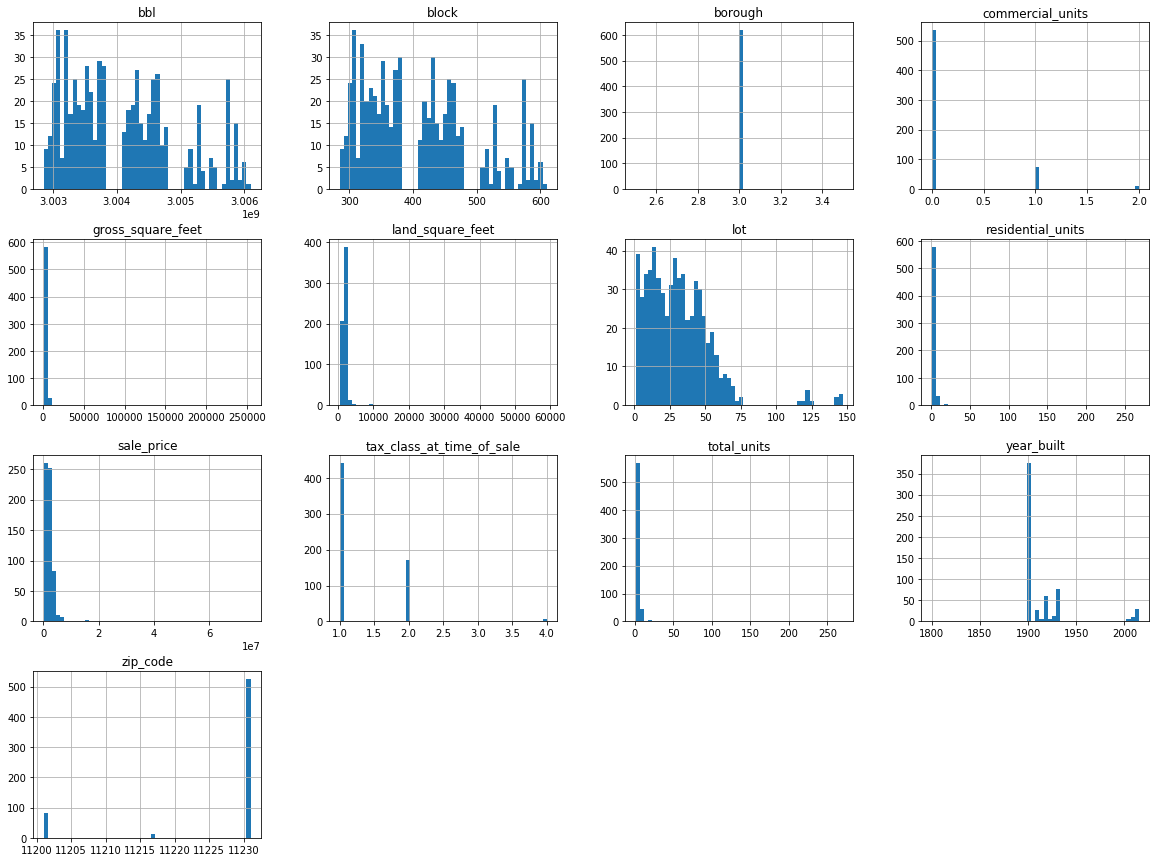

In [225]:
# Exploration on each features 
study_area_prices_new.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [226]:
corr_matrix = study_area_prices_new.corr()
corr_matrix["sale_price"].sort_values(ascending=False)

sale_price                   1.000000
gross_square_feet            0.919044
land_square_feet             0.896975
residential_units            0.887468
total_units                  0.885995
year_built                   0.225593
commercial_units             0.129561
tax_class_at_time_of_sale    0.094136
lot                         -0.035252
zip_code                    -0.106827
block                       -0.148107
bbl                         -0.148108
borough                           NaN
Name: sale_price, dtype: float64

## gross_square_feet has highest correlation to sale_price

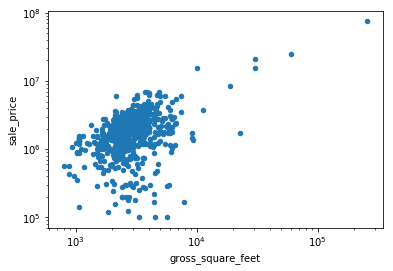

In [229]:
study_area_prices_new.plot(x='gross_square_feet',y='sale_price',kind='scatter',logx=True,logy=True)

In [230]:
lm = smf.ols(formula='sale_price~gross_square_feet-1', data = study_area_prices_new).fit()
## "-1" means no intercept 
print(lm.summary())

                            OLS Regression Results                            
Dep. Variable:             sale_price   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.823
Method:                 Least Squares   F-statistic:                     2884.
Date:                Tue, 23 Apr 2019   Prob (F-statistic):          9.02e-235
Time:                        19:57:43   Log-Likelihood:                -9756.9
No. Observations:                 618   AIC:                         1.952e+04
Df Residuals:                     617   BIC:                         1.952e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------
gross_square_feet   335.0973      6.23

In [234]:
predicted_price = lm.predict()
study_area_prices_new.loc[:, 'predicted_price'] = lm.predict()

In [235]:
study_area_prices_new[['sale_price','predicted_price']].head()

,sale_price,predicted_price
6145,1600600,1.125927e+06
6146,1699999,1.182223e+06
6147,525000,7.077255e+05
6151,312000,5.951328e+05
6152,1693500,8.233341e+05


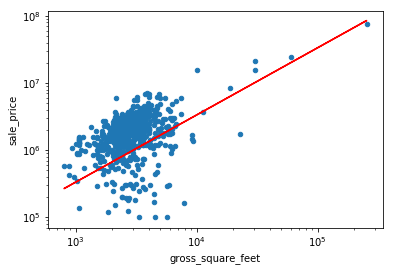

In [239]:
study_area_prices_new.plot(x='gross_square_feet',y='sale_price',kind='scatter',logx=True,logy=True)
plt.plot(study_area_prices_new.gross_square_feet,study_area_prices_new.predicted_price,'r-')
plt.show()

## Build and train a linear regression model 

In [258]:
X = study_area_prices_new[['gross_square_feet', 'land_square_feet', 'residential_units', 'total_units', 'year_built', 'commercial_units']]
Y = study_area_prices_new['sale_price']

X.head()


,gross_square_feet,land_square_feet,residential_units,total_units,year_built,commercial_units
6145,3360,1361,2,2,1899,0
6146,3528,2100,2,2,1899,0
6147,2112,1650,2,2,1901,0
6151,1776,1667,2,2,1901,0
6152,2457,1560,2,2,1931,0


In [259]:
from sklearn.cross_validation import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=999)

from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [244]:
# calculate R square 

y_pred = regressor.predict(X_test)
print('Linear Regression R squared": %.4f' % regressor.score(X_test, y_test))

Linear Regression R squared": 0.8673


### So, in linear regression model, 86.73% of the variability in Y can be explained using X.

In [245]:
# Calculate root-mean-square error (RMSE)

from sklearn.metrics import mean_squared_error
lin_mse = mean_squared_error(y_pred, y_test)
lin_rmse = np.sqrt(lin_mse)
print('Linear Regression RMSE: %.4f' % lin_rmse)

Linear Regression RMSE: 1999947.2172


### Our model was able to predict the value of every house in the test set within 1999947.2172 usd of the real price.

In [246]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(y_pred, y_test)
print('Linear Regression MAE: %.4f' % lin_mae)

Linear Regression MAE: 1020073.9386


## Build and train Random Forest 

In [247]:
from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor(random_state=42)
forest_reg.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=42,
           verbose=0, warm_start=False)

In [248]:
print('Random Forest R squared": %.4f' % forest_reg.score(X_test, y_test))

Random Forest R squared": 0.3553


In [249]:
y_pred = forest_reg.predict(X_test)
forest_mse = mean_squared_error(y_pred, y_test)
forest_rmse = np.sqrt(forest_mse)
print('Random Forest RMSE: %.4f' % forest_rmse)

Random Forest RMSE: 4407628.0354


### Linear Regression model performs better than Random forest model

## Exploratory Data Analysis on two types of housing

In [215]:
#divide residencial type to single family housing and multi-family housing 
sfam=study_area_prices_.residential_units==1
mfam=study_area_prices_.residential_units>1

In [216]:
#locate data
price_sf=study_area_prices_.loc[sfam]
price_mf=study_area_prices_.loc[mfam]

In [219]:
study_area_prices_.size

13596

In [220]:
price_mf.size

11572

In [218]:
price_sf.size

2024

In [178]:
#Single unit correlation
price_sf[['year_built','gross_square_feet','land_square_feet','sale_price']].corr()

,year_built,gross_square_feet,land_square_feet,sale_price
year_built,1.000000,0.496423,0.088125,0.290406
gross_square_feet,0.496423,1.000000,0.486133,0.648900
land_square_feet,0.088125,0.486133,1.000000,0.118667
sale_price,0.290406,0.648900,0.118667,1.000000


In [179]:
#multi-unit housing correlation 
price_mf[['year_built','gross_square_feet','land_square_feet','sale_price']].corr()

,year_built,gross_square_feet,land_square_feet,sale_price
year_built,1.000000,0.220275,0.204630,0.237357
gross_square_feet,0.220275,1.000000,0.986688,0.937829
land_square_feet,0.204630,0.986688,1.000000,0.928311
sale_price,0.237357,0.937829,0.928311,1.000000


#### Single family housing has strong correlation with gross_square_feet, multi-family housing has string correlation both on gross_square_feet and land_square_feet

# Housing Price trend in Red Hook

Next Step: 
    1. Housing price trend visulization
    2. Apply time series analysis on property price in red hook
    3. Try other model for prediction
    4. Use on other rezoning area(housing price) for validation